## Follows Create_peak_by_tissue_and_Cluster

In [1]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
import tqdm
### notebook specific configuration ###
from os.path import basename
mpl.style.use('fivethirtyeight')

from Modules.Homer import *

sys.path.append('/home/isshamie/software/NGS-Pipeline')

data_folder = '/data/isshamie/CH_tissue_TSS/'

ref_fa = '/data/genome/hamster/picr/picr.fa'
annotation = '/data/genome/hamster/picr/updated_final_sort.gff3'
tss_annotation = '/data/isshamie/genome/start_site_mRNA_updated_final_sort.tsv'
mrna_peak = '/data/isshamie/TSS_CHO/mRNA.peak'

tissues = ['BloondnegSpleen','BMDM1hKLA1','BMDMwt','Brain','Brain7neg1',
          'FemaleReproductive','Heart','Intestine','Kidney','Liver','Lung',
           'MiscOrgans','Muscle','Pancreas','Skin','Spleen','Total','CHO']

len(tissues)

### Load in meta_sampe

meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)

long_meta_samples = pd.read_csv('Results/long_meta_samples.csv',index_col=0)


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
from tqdm import tqdm_notebook

In [3]:
peak_tissue_matrix = pd.read_csv('Results/merged_samples/peaks_tissues.csv',index_col=0)

In [4]:
anno_peaks = pd.read_csv('Results/merged_samples/all_peaks_merged_anno.tsv',sep='\t',index_col=0)
anno_peaks.dropna(axis=1,how='all',inplace=True)
anno_peaks = anno_peaks.fillna('')
# promoter_peaks = anno_peaks[anno_peaks['Annotation'].str.contains('promoter')]
# promoter_peaks_index = promoter_peaks.index
# promoter_tissue_matrix = peak_tissue_matrix[peak_tissue_matrix.index.isin(promoter_peaks_index)]

In [5]:
print 'Number of promoter peaks: ',len(promoter_peaks)
print 'Number of Unique annotations: ' , len(promoter_peaks.groupby('Annotation'))

Number of promoter peaks:  104320
Number of Unique annotations:  64895


## Load in the unique TSS gff file

In [5]:
tss = pd.read_csv(tss_annotation,sep='\t',index_col=0)

In [6]:
### Need to create an extra column for tss called 'actual_start'. 
### This is to take care of issue of a gene starting at the End when it's on the minus strand
tss['actual_start'] = tss.apply( lambda x: x['Start'] if x['Strand'] == '+' else x['End'],axis=1)

In [ ]:
tss.head()

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length,actual_start
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gene=SERHL;transcript_id=asmbl_2;cs=2,picr_0,176,38694,+,asmbl_2,gene_1_2,gene_1_2,SERHL,asmbl_2,2,38518,176
ID=asmbl_4;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_4;cs=1,picr_0,7715,46630,-,asmbl_4,gene_2,gene_2,RRP7A,asmbl_4,1,38915,46630
ID=asmbl_7;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_7;cs=1,picr_0,7759,44597,-,asmbl_7,gene_2,gene_2,RRP7A,asmbl_7,1,36838,44597
ID=asmbl_8;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_8;cs=1,picr_0,7767,44597,-,asmbl_8,gene_2,gene_2,RRP7A,asmbl_8,1,36830,44597
ID=asmbl_9;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_9;cs=1,picr_0,7789,44568,-,asmbl_9,gene_2,gene_2,RRP7A,asmbl_9,1,36779,44568


## Take peaks +100 to -1kb
### Create additional column with the nearest TSS 
### Groupby that column, histogram of how many peaks per TSS
#### Also determine a) average distance between start sites b) scatter plot of top 2 highest, if only one, color that one but just duplicate it


In [ ]:
anno_peaks['Nearest TSS'] = ''
anno_peaks['Distance to TSS'] = np.infty
anno_peaks['isSameStrand'] = False

for ind,val in tqdm_notebook(anno_peaks.iterrows()):
    filt = tss[val['Chr'] == tss['Chr']]
    peak_start = (val['Start']+val['End'])/2
    if len(filt) != 0:
        filt2 = np.abs(filt['actual_start'] - peak_start).argmin()
        anno_peaks.set_value(ind,'Nearest TSS',tss.loc[filt2,'transcript_id'])
        
        anno_peaks.set_value(ind,'Nearest gene',tss.loc[filt2,'gene'])
        anno_peaks.set_value(ind,'Nearest gene_id',tss.loc[filt2,'gene_id'])
        
        ## Get distance to nearest gene. If on - strand, tss 'End' is the beginning
        anno_peaks.set_value(ind,'Distance to TSS',peak_start - tss.loc[filt2,'actual_start'])
#         if tss.loc[filt2,'Strand'] == '+':   
#             anno_peaks.set_value(ind,'Distance to TSS',peak_start - tss.loc[filt2,'Start'])
#         elif tss.loc[filt2,'Strand'] == '-': 
#             anno_peaks.set_value(ind,'Distance to TSS',tss.loc[filt2,'End']-peak_start) 
#         else:
#             print 'No chr??'
        
        anno_peaks.set_value(ind,'isSameStrand',val['Strand'] == tss.loc[filt2,'Strand'])


In [ ]:
anno_peaks.to_csv('Results/peaks_with_tss_and_gene.tsv',sep='\t')

In [ ]:
print('gene id:', len(anno_peaks.groupby('Nearest gene_id')))
print('gene:',len(anno_peaks.groupby('Nearest gene')))
print('TSS:',len(anno_peaks.groupby('Nearest TSS')))

### txn to gene map

In [ ]:
%%time
txn_to_gene = dict()
txns = set(tss['transcript_id'])
for tx in tqdm_notebook(txns):
    txn_to_gene[tx] = tss[tss['transcript_id'] == tx]['gene'][0]
    


In [15]:
for key in txn_to_gene:
    txn_to_gene[key] = txn_to_gene[key][0]

In [17]:
pickle.dump(txn_to_gene,open('Results/txn_to_gene','wb'))

### How many peaks for a specific gene. 

In [29]:
anno_peaks = pd.read_csv('Results/peaks_with_tss_and_genes.tsv',sep='\t',index_col=0)

In [ ]:
def get_genes_peaks(peaks,gene,distance=[-1000,+100]):
    
    filt = peaks[(peaks['Nearest gene'] == gene) & 
                 ((peaks['Distance to TSS'] > distance[0]) & (peaks['Distance to TSS'] < distance[1]))]
    return filt

def get_nearest_tss(peaks_gene): 
    #peaks of one gene
    peaks_gene['abs'] = np.abs(peaks_gene['Distance to TSS'])
    idx = peaks_gene['abs'].argmin()
    return idx, peaks_gene.loc[idx,'Distance to TSS']


def tss_per_gene(peaks_gene): 
    #peaks of one gene
    return len(set(peaks_gene['Nearest TSS']))


def tissues_gene_expressed(peaks_gene,peaks_tissue_matrix):
    #peaks of one gene
    curr_gene_vals = peaks_tissue_matrix[peaks_tissue_matrix.isin(peaks_gene.idnex)]
    tiss = (curr_gene_vals > 1).any(axis=1)
    tiss = tiss.columns[tiss]
    return tiss

In [ ]:
gene_list = tss['gene'].unique()
gene_pd = pd.DataFrame(index=gene_list,columns=['Peaks','Number of Peaks','Tissues','minDistance',
                                                'sameStrandPeaks','minDistancePeak','maxValue','Peaks within -1kb:+100bp'])
gene_pd['Number of Peaks'] = 0
gene_pd['Peaks'] = ''
gene_pd['minDistance'] = 0
gene_pd['minDistancePeak'] = ''
gene_pd['tissues'] = ''
#gene_pd['Peaks'] = [[] for _ in range(gene_pd.shape[0])]

for i in tqdm_notebook(anno_peaks.groupby(['Nearest gene'])):
    curr_gene = i[0]
    gene_pd.loc[curr_gene,'Number of Peaks'] += len(i[1])
    curr = i[1]
    gene_pd.set_value(curr_gene,'Peaks',list(curr.index))
    
    ## Filter to only within the distance of -1kb to +100bp
    curr = get_genes_peaks(curr,curr_gene,distance=[-1000,+100])
    gene_pd.set_value(curr_gene,'Peaks within -1kb:+100bp',list(curr.index))
    
    ## isSameStrand 
    same_strand = curr[curr['isSameStrand'] == True]
    gene_pd.set_value(curr_gene,'sameStrandPeaks',list(same_strand.index))
    ## Find closest peak
    if len(same_strand) > 0:
        minPeak, minPeakValue = get_nearest_tss(same_strand)
        gene_pd.set_value(curr_gene,'minDistance',minPeakValue)
        gene_pd.set_value(curr_gene,'minDistancePeak',minPeak)
    
    ## Tissues
    try: 
        curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[curr.index]>0).any()].values
        curr_tissues = map(lambda x: x.split('/')[0] + '_' + x.split('/')[1],curr_tissues)
        gene_pd.set_value(curr_gene,'tissues',curr_tissues)
    except KeyError :
        print curr.index + ' not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'
    
    ## Strongest peak

gene_pd['hasGene'] = gene_pd.fillna('')['sameStrandPeaks'].apply(lambda x: len(x) > 0)
gene_pd['Number of SS'] = gene_pd['sameStrandPeaks'].fillna('').apply(lambda x: len(x))

In [ ]:
gene_pd.to_csv("Results/gene_pd.tsv",sep='\t')

In [ ]:
gene_pd.to_pickle('Results/gene_pd.p')


In [19]:

print('Total Number of genes: ', len(gene_pd))
print('Total Number of genes with start sites: ',np.sum(gene_pd['hasGene']))
print('Fraction of start sites: ',1.0*np.sum(gene_pd['hasGene'])/len(gene_pd))

('Total Number of genes: ', 17246)
('Total Number of genes with start sites: ', 12881)
('Fraction of start sites: ', 0.7468978313811898)


### How many peaks for a specific gene. 
### How many tissues 
### What was the strongest peak
### Distance between peaks (if we separate the transcripts out)
### How many start sites


('Number of genes with greater than 10 peaks:', 22)


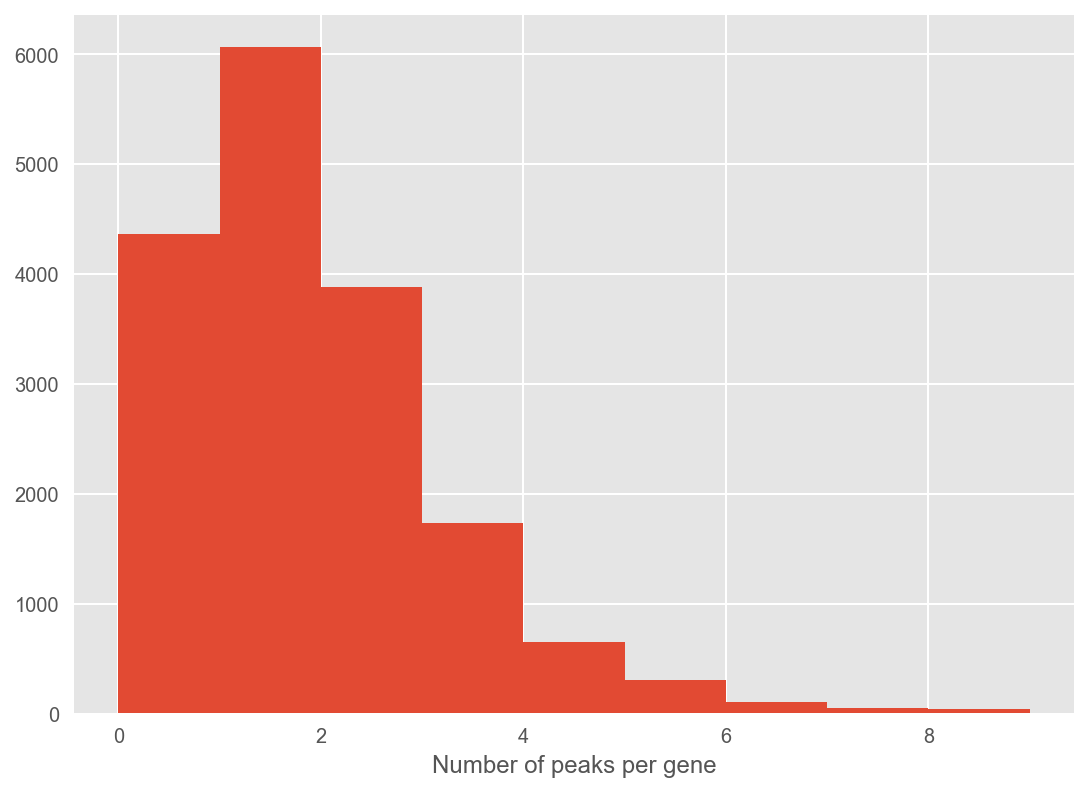

In [18]:
#sns.distplot(start_sites_gff['Experimental'],kde=False,norm_hist=False)

f = plt.figure();
ax = f.add_subplot(1,1,1);
#ax.hist(gene_pd['Number of SS']);
gene_pd_small = gene_pd[gene_pd['Number of SS']<10]
ax.hist(gene_pd_small['Number of SS'],bins=max(gene_pd_small['Number of SS']))
ax.set_xlabel('Number of peaks per gene')
#ax.set_xticks(range(0,max(gene_pd['Number of SS'])+1,2))
print('Number of genes with greater than 10 peaks:',np.sum(gene_pd['Number of SS']>10))
plt.savefig('Results/Figures/Number_of_peaks_per_gene.png')

## Clustering

In [4]:
gene_pd = pickle.load(open("Results/gene_pd.p",'rb'))

In [5]:
def gene_pd_to_TSS_expression(gene_pd,peak_tissue_matrix):
    ''' Create geneXpeakValue matrix where rows are genes and cols are tissues.
    For each gene, take all the peaks that match that, and for each tissue, take its max expression for each tissue
    '''
    gene_tissue_matrix = pd.DataFrame(index=gene_pd.index,columns=peak_tissue_matrix.columns,dtype='float32').fillna(0)

    for ind,val in tqdm_notebook(gene_pd.iterrows()):
        if type(val['sameStrandPeaks']) == list:#type(val['sameSt'~np.isnan(val['sameStrandPeaks']):
            curr_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(val['sameStrandPeaks'])]
            gene_tissue_matrix.loc[ind] = curr_peaks.max()
    gene_tissue_matrix.fillna(0,inplace=True)
    return gene_tissue_matrix

In [6]:
gene_tissue_matrix = gene_pd_to_TSS_expression(gene_pd,peak_tissue_matrix)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [8]:
gene_tissue_matrix.to_csv('Results/merged_samples/genes_tissues.csv')

In [11]:
gene_tissue_matrix.head()

,BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak,BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak,BMDMwt/GRO/f04_peaks/merge_bg_2.peak,Brain/GRO/f04_peaks/merge_bg_2.peak,Brain/mSTART/f04_peaks/merge_bg_2.peak,FemaleReproductive/mSTART/f04_peaks/merge_bg_2.peak,Heart/mSTART/f04_peaks/merge_bg_2.peak,Kidney/GRO/f04_peaks/merge_bg_2.peak,Kidney/mSTART/f04_peaks/merge_bg_2.peak,Liver/GRO/f04_peaks/merge_bg_2.peak,Liver/mSTART/f04_peaks/merge_bg_2.peak,Lung/GRO/f04_peaks/merge_bg_2.peak,Lung/mSTART/f04_peaks/merge_bg_2.peak,MiscOrgans/mSTART/f04_peaks/merge_bg_2.peak,Muscle/mSTART/f04_peaks/merge_bg_2.peak,Pancreas/mSTART/f04_peaks/merge_bg_2.peak,Spleen/mSTART/f04_peaks/merge_bg_2.peak,CHO/GRO/f04_peaks/merge_bg_2.peak,CHO/mSTART/f04_peaks/merge_bg_2.peak
SERHL,188.199997,13.300000,90.199997,333.500000,501.799988,1089.349976,777.750000,453.299988,18793.900391,374.600006,337.950012,294.100006,282.199982,697.300049,593.450012,529.299988,201.000000,971.449951,819.599976
RRP7A,0.000000,0.000000,0.000000,25.299999,27.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.650000,0.000000,0.000000,91.099998,0.000000,34.299999
POLDIP3,135.199997,43.700001,114.599998,122.599998,775.000000,1285.000000,1082.199951,84.199997,609.299988,85.099998,958.000000,132.199997,0.000000,1020.000000,1550.399902,311.899994,757.200012,317.799988,738.700012
CYB5R3,43.500000,0.000000,45.099998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A4GALT,30.799999,324.600006,257.299988,59.900002,0.000000,136.250000,345.149994,85.300003,48.950001,0.000000,0.000000,95.199997,0.000000,98.949997,291.750000,0.000000,37.400002,0.000000,0.000000


In [50]:
gene_tissue_matrix.fillna(0,inplace=True)

In [51]:
short_gene_tissue = gene_tissue_matrix[~(np.sum(gene_tissue_matrix == 0,axis=1) == gene_tissue_matrix.shape[1])]

print(len(gene_tissue_matrix))
print(len(short_gene_tissue))
      

17246
12878


In [37]:
gene_tissue_matrix.shape[1]

19

In [31]:
short_gene_tissue = gene_tissue_matrix[~(np.sum(gene_tissue_matrix == 0,axis=1) == gene_tissue_matrix.shape[1])]

### Binary

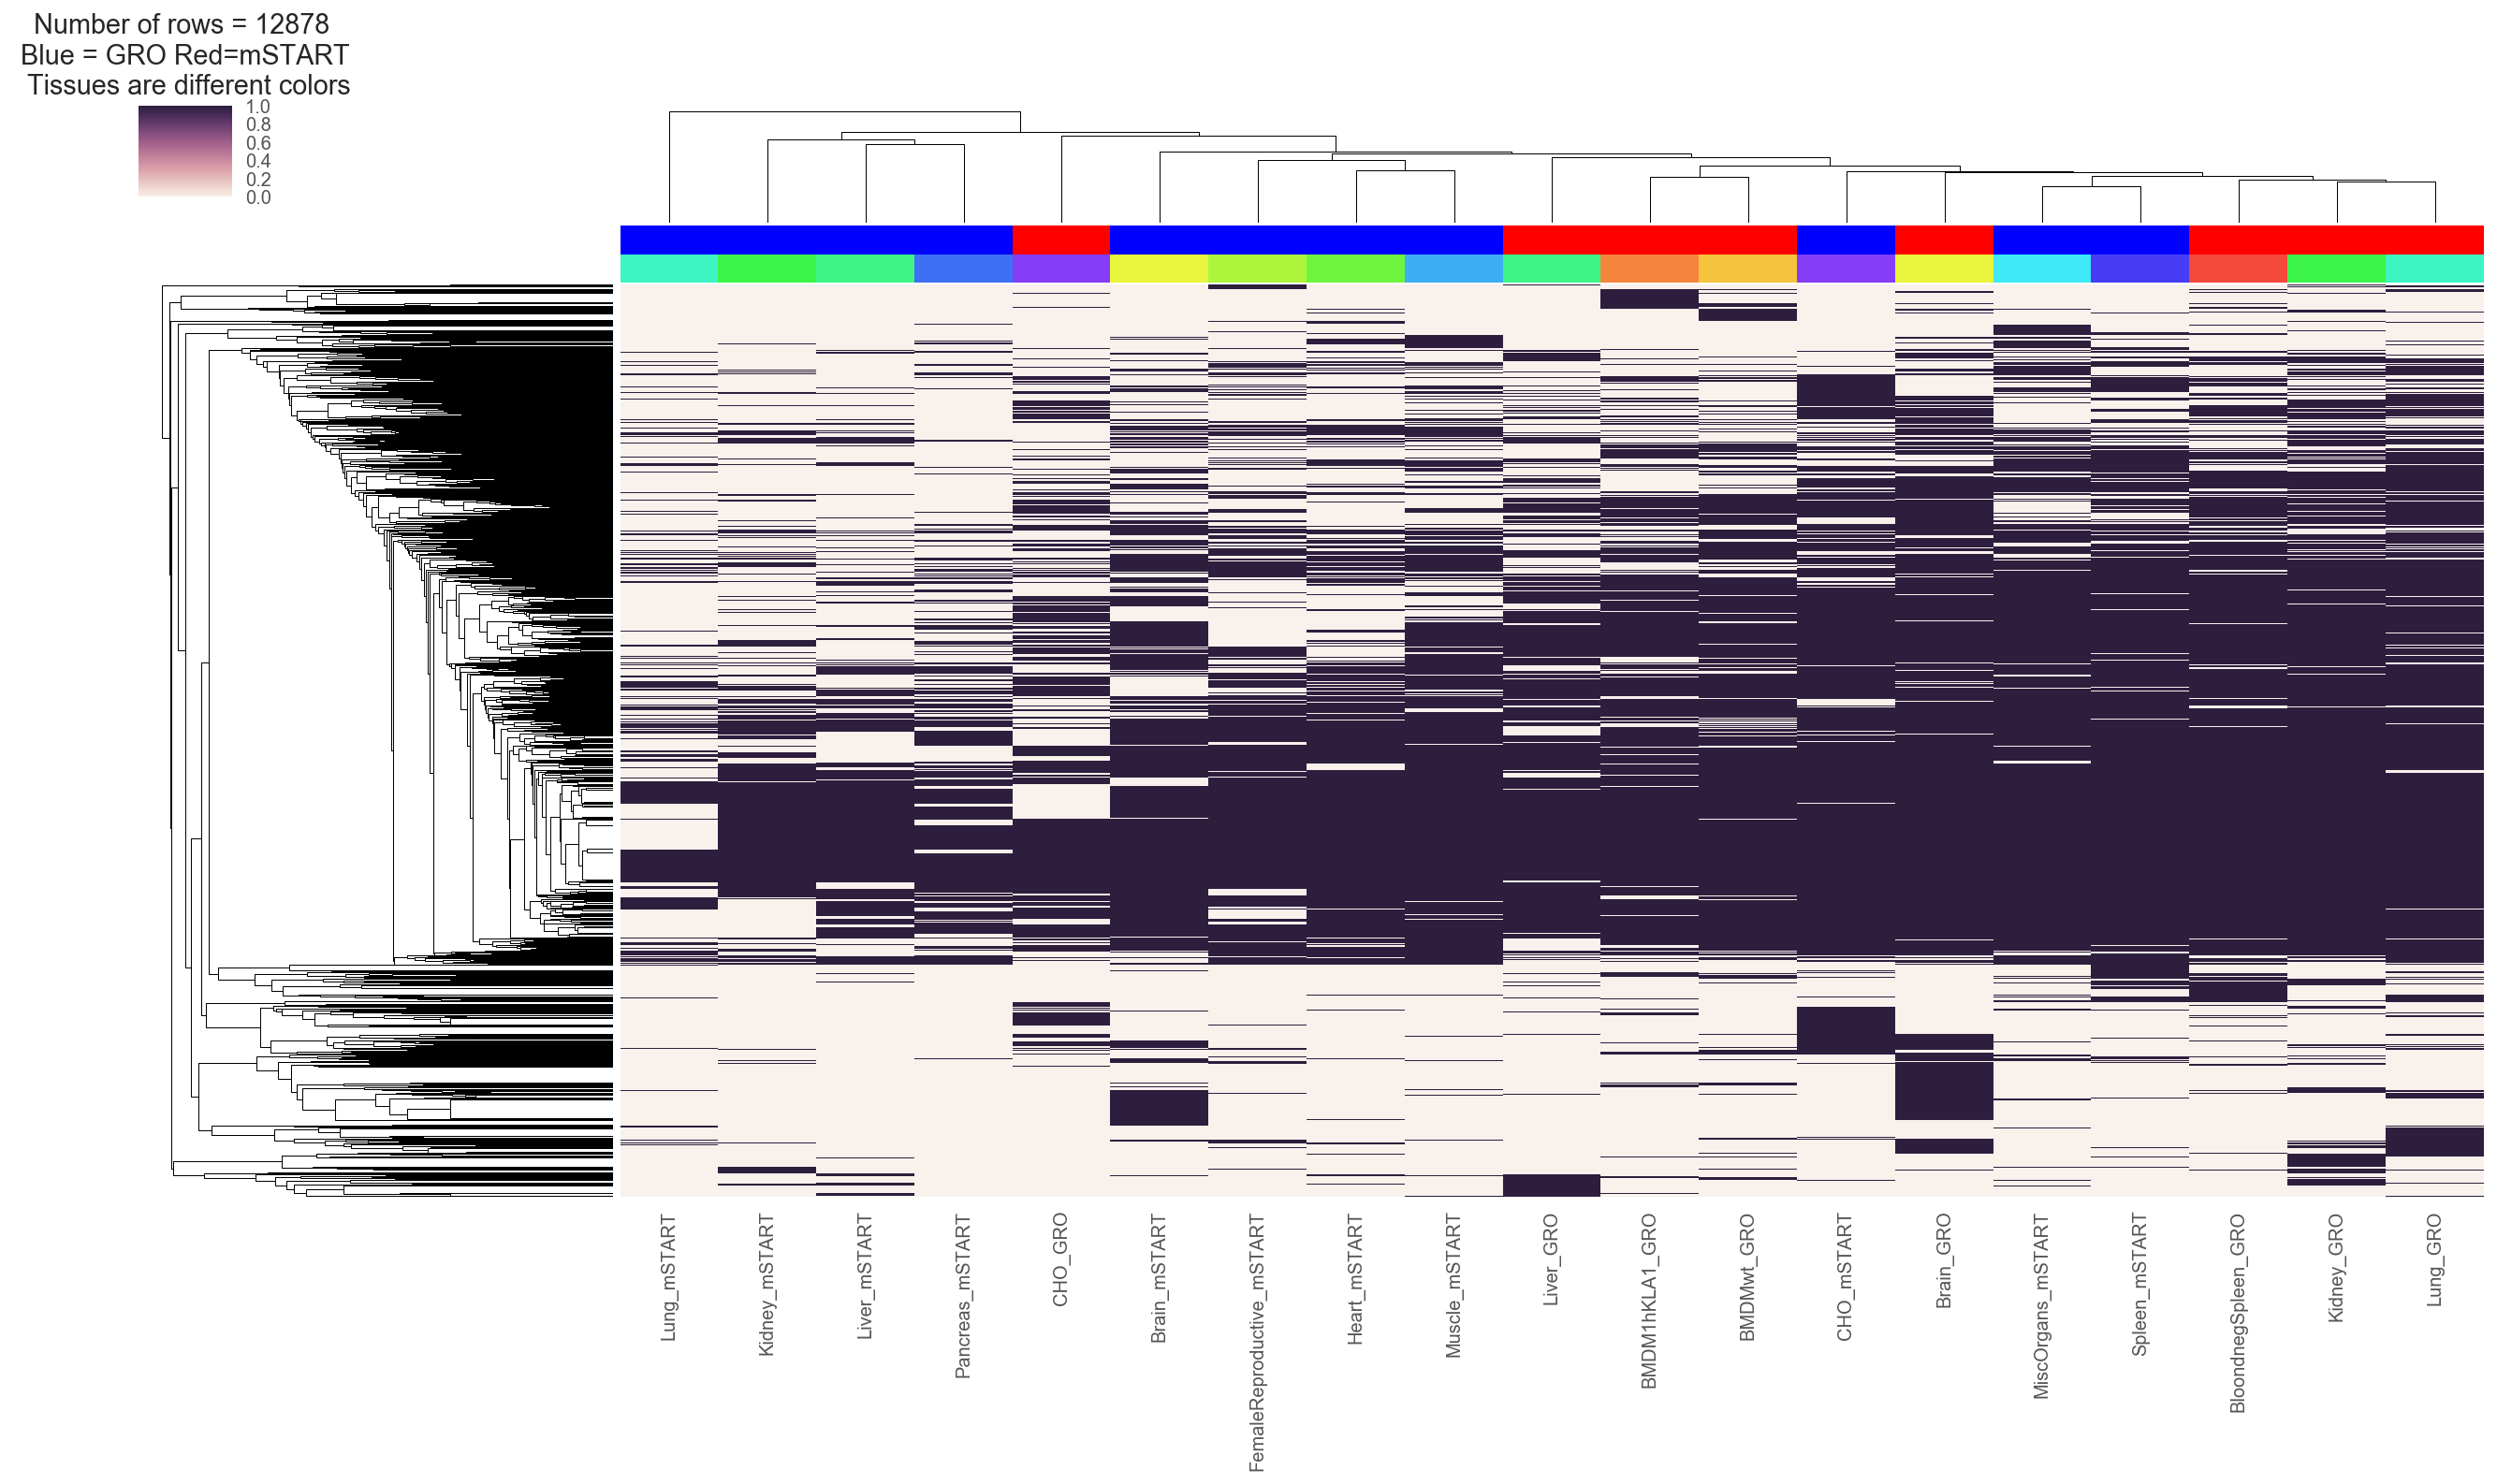

In [52]:
n_tis = len(set(meta_samples['Tissue']))


lut = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].unique(), "rbg"))
col_colors = meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].map(lut)

lut2 = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
col_colors2 = meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].map(lut2)

g = sns.clustermap((short_gene_tissue>0),col_cluster=True,figsize=(20,10),metric='jaccard',
                   yticklabels=False,col_colors=[col_colors,col_colors2],xticklabels=meta_samples.loc[short_gene_tissue.columns.values,'Short'])

# g = sns.clustermap(short_gene_tissue,col_cluster=True,figsize=(20,10),metric='jaccard',row_cluster=False
#                    ,yticklabels=False)

title = 'Number of rows = %d \n Blue = GRO Red=mSTART \n Tissues are different colors' % len(short_gene_tissue)
plt.title(title)
g.savefig('Results/Figures/binary_promoter_gene_cluster.png',bbox_inches='tight')

In [55]:
gene_pd.shape

(17246, 11)

In [54]:
np.sum((short_gene_tissue>0))

BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak          7954
BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak               6696
BMDMwt/GRO/f04_peaks/merge_bg_2.peak                   7068
Brain/GRO/f04_peaks/merge_bg_2.peak                    9063
Brain/mSTART/f04_peaks/merge_bg_2.peak                 6500
FemaleReproductive/mSTART/f04_peaks/merge_bg_2.peak    5413
Heart/mSTART/f04_peaks/merge_bg_2.peak                 5508
Kidney/GRO/f04_peaks/merge_bg_2.peak                   8493
Kidney/mSTART/f04_peaks/merge_bg_2.peak                3819
Liver/GRO/f04_peaks/merge_bg_2.peak                    6205
Liver/mSTART/f04_peaks/merge_bg_2.peak                 3786
Lung/GRO/f04_peaks/merge_bg_2.peak                     8642
Lung/mSTART/f04_peaks/merge_bg_2.peak                  2596
MiscOrgans/mSTART/f04_peaks/merge_bg_2.peak            7729
Muscle/mSTART/f04_peaks/merge_bg_2.peak                6631
Pancreas/mSTART/f04_peaks/merge_bg_2.peak              3926
Spleen/mSTART/f04_peaks/merge_bg_2.peak 

In [61]:
np.sum((short_gene_tissue>0))/gene_pd.shape[0]

BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak          0.461208
BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak               0.388264
BMDMwt/GRO/f04_peaks/merge_bg_2.peak                   0.409834
Brain/GRO/f04_peaks/merge_bg_2.peak                    0.525513
Brain/mSTART/f04_peaks/merge_bg_2.peak                 0.376899
FemaleReproductive/mSTART/f04_peaks/merge_bg_2.peak    0.313870
Heart/mSTART/f04_peaks/merge_bg_2.peak                 0.319378
Kidney/GRO/f04_peaks/merge_bg_2.peak                   0.492462
Kidney/mSTART/f04_peaks/merge_bg_2.peak                0.221443
Liver/GRO/f04_peaks/merge_bg_2.peak                    0.359794
Liver/mSTART/f04_peaks/merge_bg_2.peak                 0.219529
Lung/GRO/f04_peaks/merge_bg_2.peak                     0.501102
Lung/mSTART/f04_peaks/merge_bg_2.peak                  0.150528
MiscOrgans/mSTART/f04_peaks/merge_bg_2.peak            0.448162
Muscle/mSTART/f04_peaks/merge_bg_2.peak                0.384495
Pancreas/mSTART/f04_peaks/merge_bg_2.pea

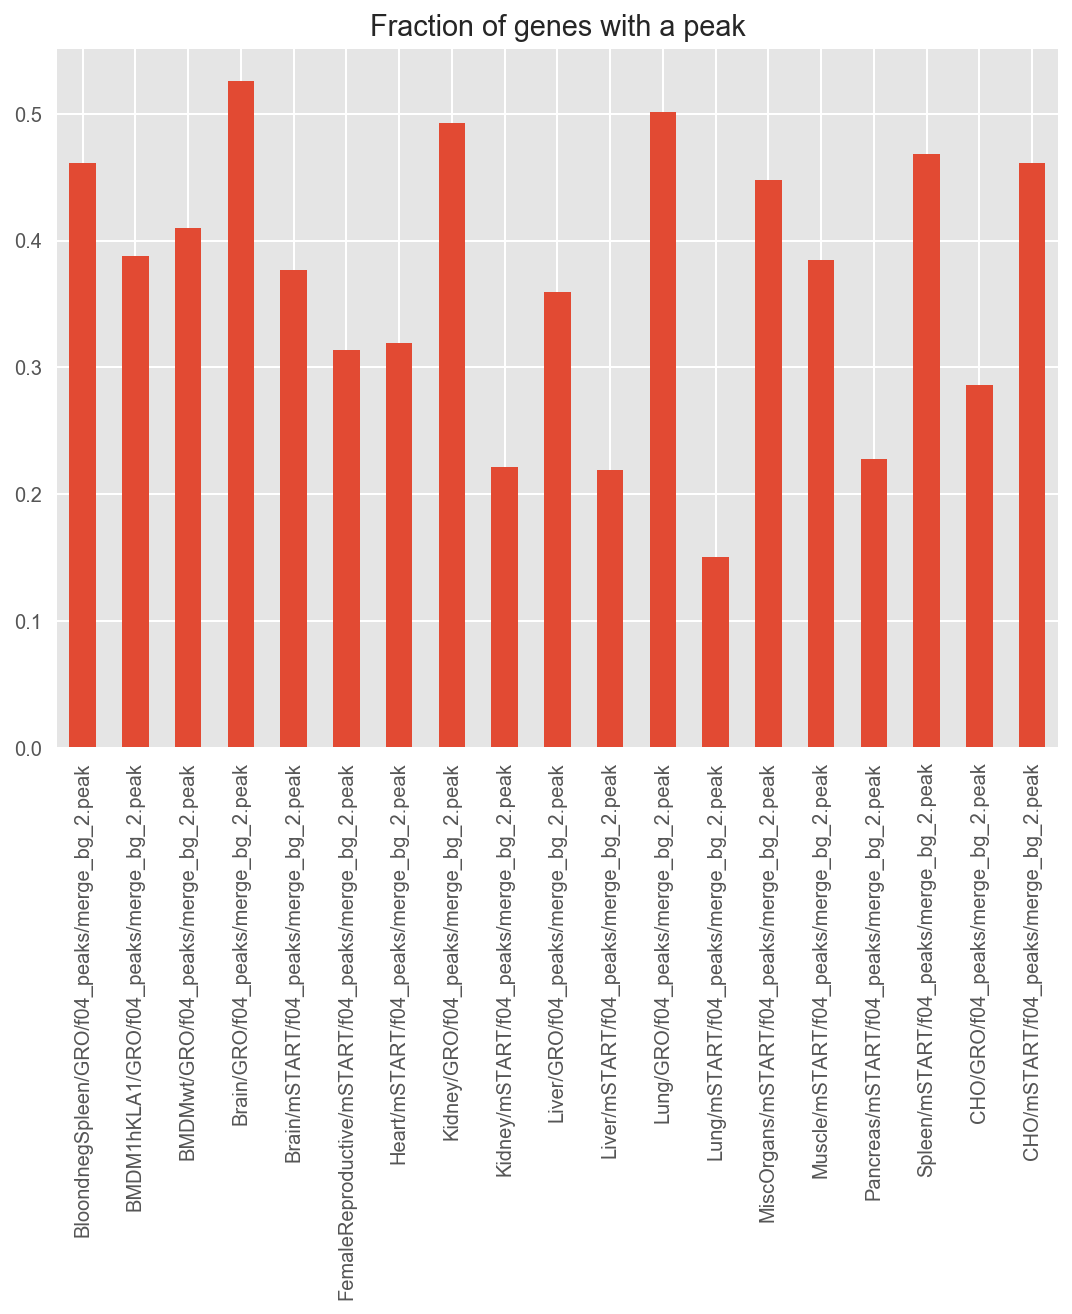

In [63]:
f = plt.figure()
ax = (np.sum((short_gene_tissue>0))/gene_pd.shape[0]).plot.bar()
ax.set_title('Fraction of genes with a peak')

### log2(val+1)

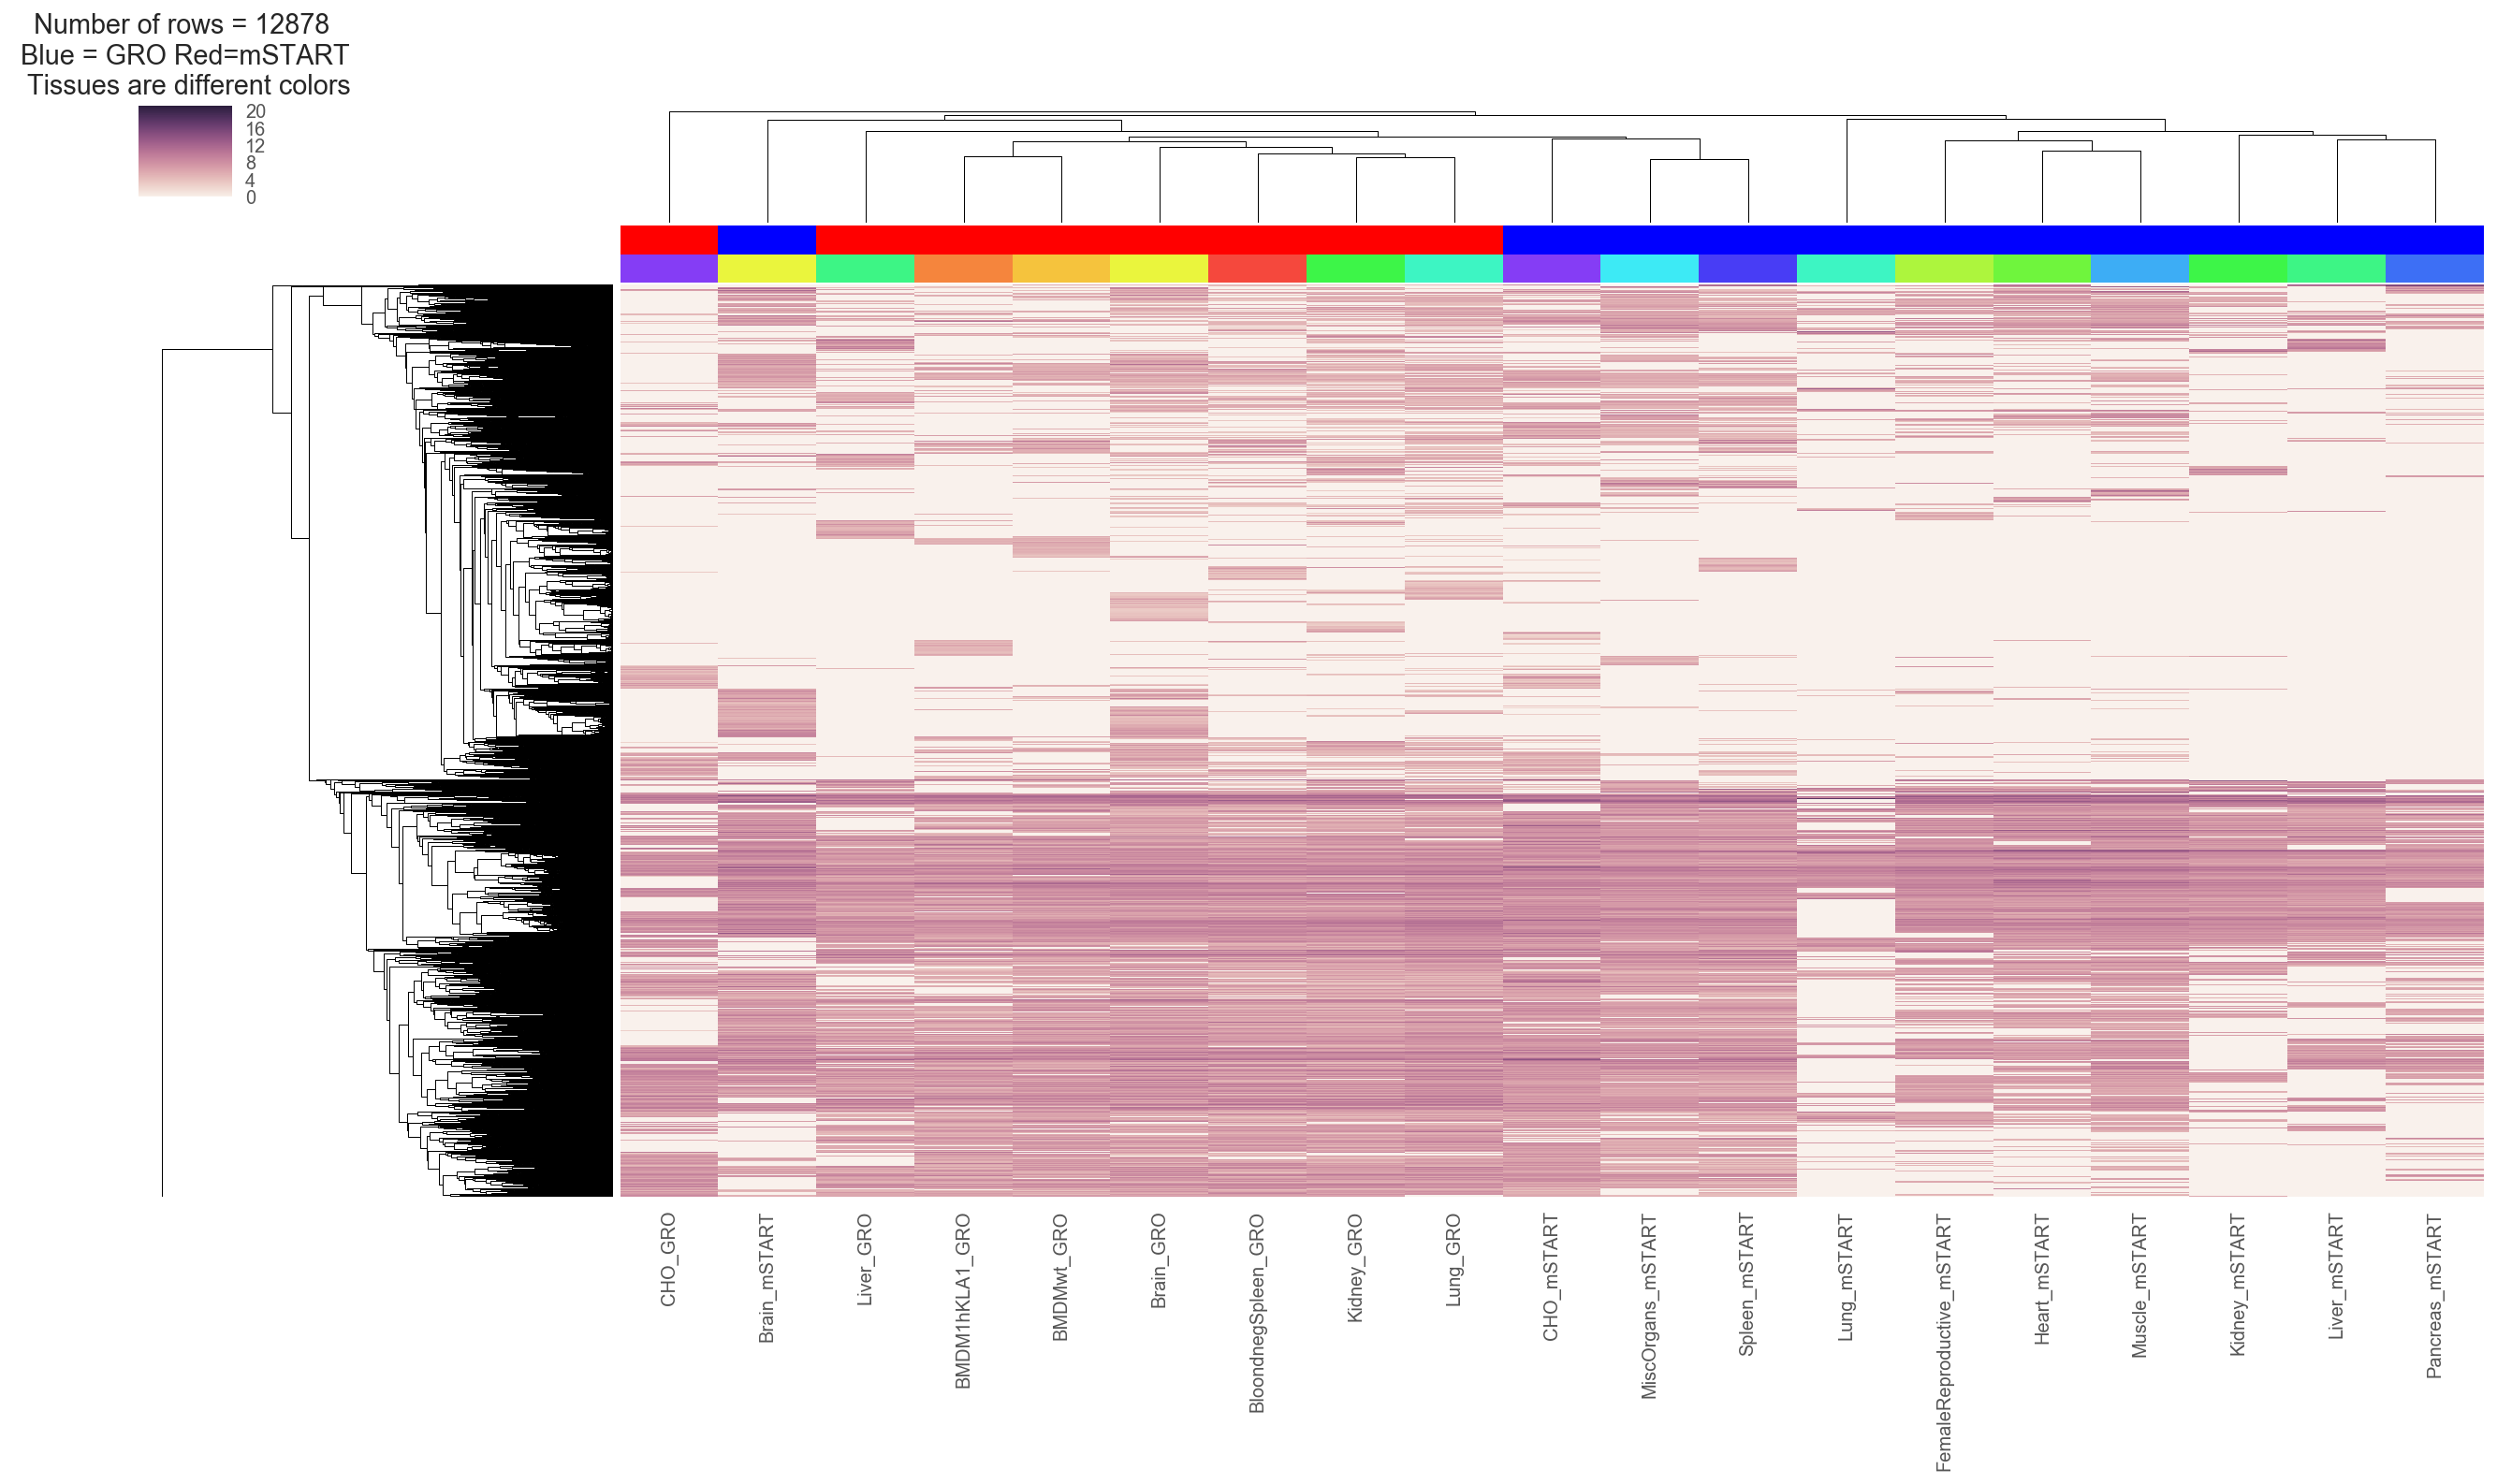

In [53]:
n_tis = len(set(meta_samples['Tissue']))

lut = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].unique(), "rbg"))
col_colors = meta_samples.loc[short_gene_tissue.columns.values,'Experiment'].map(lut)

lut2 = dict(zip(meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
col_colors2 = meta_samples.loc[short_gene_tissue.columns.values,'Tissue'].map(lut2)

g = sns.clustermap(np.log2(short_gene_tissue+1),
                   col_cluster=True,
                   figsize=(20,10),
                   yticklabels=False,
                   col_colors=[col_colors,col_colors2],
                   xticklabels=meta_samples.loc[short_gene_tissue.columns.values,'Short'])


title = 'Number of rows = %d \n Blue = GRO Red=mSTART \n Tissues are different colors' % len(short_gene_tissue)
plt.title(title)
g.savefig('Results/Figures/promoter_gene_cluster.png',bbox_inches='tight')

#### Scrap

In [ ]:
ind = anno_peaks[anno_peaks['Nearest gene'] == 'TBC1D9'].iloc[0].index #'TBC1D9'
val = anno_peaks[anno_peaks['Nearest gene'] == 'TBC1D9'].iloc[0].index
filt = tss[val['Chr'] == tss['Chr']]
peak_start = (val['Start']+val['End'])/2
if len(filt) != 0:
    filt2 = np.abs(filt['Start'] - peak_start).argmin()
    print(ind,'Nearest TSS',tss.loc[filt2,'transcript_id'])

    print(ind,'Nearest gene',tss.loc[filt2,'gene'])
    print(ind,'Nearest gene_id',tss.loc[filt2,'gene_id'])

    ## Get distance to nearest gene. If on - strand, tss 'End' is the beginning
    if tss.loc[filt2,'Strand'] == '+':   
        print(ind,'Distance to TSS',peak_start - tss.loc[filt2,'Start'])
    elif tss.loc[filt2,'Strand'] == '-': 
        print(ind,'Distance to TSS',tss.loc[filt2,'End']-peak_start) 
    else:
        print 'No chr??'

    #anno_peaks.set_value(ind,'isSameStrand',val['Strand'] == tss.loc[filt2,'Strand'])


In [24]:
(182591+182741)/2 - 277575

-94909

In [22]:
tss[tss['gene'] == 'TBC1D9']

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length
ID=asmbl_22767;Parent=gene_7718_1;gene_id=gene_7718_1;gene=TBC1D9;transcript_id=asmbl_22767;cs=1,picr_151,191144,277575,-,asmbl_22767,gene_7718_1,gene_7718_1,TBC1D9,asmbl_22767,1,86431
ID=asmbl_22769;Parent=gene_7718_1;gene_id=gene_7718_1;gene=TBC1D9;transcript_id=asmbl_22769;cs=1,picr_151,191145,291835,-,asmbl_22769,gene_7718_1,gene_7718_1,TBC1D9,asmbl_22769,1,100690
ID=asmbl_22770;Parent=gene_7718_1;gene_id=gene_7718_1;gene=TBC1D9;transcript_id=asmbl_22770;cs=1,picr_151,192499,211561,-,asmbl_22770,gene_7718_1,gene_7718_1,TBC1D9,asmbl_22770,1,19062
ID=asmbl_22771;Parent=gene_7718_2;gene_id=gene_7718_2;gene=TBC1D9;transcript_id=asmbl_22771;cs=1,picr_151,218631,246552,-,asmbl_22771,gene_7718_2,gene_7718_2,TBC1D9,asmbl_22771,1,27921
